In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import pandas as pd
import time
import xgboost as xgb
import tensorflow as tf
import keras.utils
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, Flatten , Input, Dense, LSTM, GRU, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, multilabel_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, accuracy_score, roc_curve, auc, f1_score, confusion_matrix, recall_score, plot_confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
injury_rec_df = pd.read_pickle("Injury.plk")
injury_rec_df

,PlayerKey,GameID,PlayKey,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,1,1,1,1
...,...,...,...,...,...,...,...,...
100,44423,44423-13,NaN,Knee,1,0,0,0
101,31933,31933-20,NaN,Knee,1,0,0,0
102,47285,47285-4,NaN,Knee,1,1,0,0
103,37068,37068-19,NaN,Knee,1,1,0,0


In [4]:
playList_no_dups = pd.read_pickle('PlayList_No_Dups.plk')
playList_no_dups 

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Pass,1,QB,QB
81,26624,26624-2,26624-2-1,Quarterback,11,2,Indoor,Synthetic,85,Cloudy,Pass,1,QB,QB
157,26624,26624-3,26624-3-1,Quarterback,18,3,Outdoor,Synthetic,84,Clear,Rush,1,QB,QB
221,26624,26624-4,26624-4-1,Quarterback,25,4,Outdoor,Synthetic,61,Clear,Pass,1,QB,QB
291,26624,26624-5,26624-5-1,Quarterback,29,5,Outdoor,Natural,76,Clear,Pass,1,QB,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266741,47888,47888-9,47888-9-1,Cornerback,71,9,Outdoor,Synthetic,53,Cloudy,Pass,1,DB,DB
266795,47888,47888-10,47888-10-1,Cornerback,78,10,Outdoor,Natural,82,Cloudy,Rush,1,DB,DB
266833,47888,47888-11,47888-11-1,Cornerback,85,11,Outdoor,Natural,42,Cloudy,Pass,1,DB,DB
266889,47888,47888-12,47888-12-1,Cornerback,92,12,Outdoor,Synthetic,40,Clear,Rush,1,DB,DB


In [5]:
games_injuries_df = injury_rec_df.set_index('GameID').join(playList_no_dups.set_index('GameID'), how = 'inner',lsuffix='_left', rsuffix='_right')
target = games_injuries_df['BodyPart']
games_injuries_df.drop(columns=['PlayKey_left','PlayerKey_left','PlayerKey_right','PlayKey_right','PlayerGamePlay','BodyPart'],inplace=True)
descriptive = pd.get_dummies(games_injuries_df, dummy_na = False)
unique_values, occ_num = np.unique(target, return_counts=True)
print(dict(zip(unique_values, occ_num)))

{'Ankle': 42, 'Foot': 7, 'Heel': 1, 'Knee': 48, 'Toes': 7}


In [6]:
oversampling = RandomOverSampler(random_state=0,sampling_strategy={'Ankle':420, 'Foot':70, 'Heel':10, 'Knee':480, 'Toes':70})
X_oversampled, Y_oversampled = oversampling.fit_resample(descriptive, target)
X_oversampled

C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (420) in class Ankle will be larger than the number of samples in the majority class (class #Knee -> 48)
  warnings.warn(
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (70) in class Foot will be larger than the number of samples in the majority class (class #Knee -> 48)
  warnings.warn(
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (480) in class Knee will be larger than the number of samples in the majority class (class #Knee -> 48)
  warnings.warn(
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (70) in class

,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
0,1,1,1,1,15,3,89,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,394,20,84,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1,1,1,1,8,2,83,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,1,1,0,365,8,81,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1,1,1,0,393,19,79,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1,0,0,0,84,12,69,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1046,1,1,0,0,36,6,85,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1047,1,0,0,0,71,10,68,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1048,1,1,0,0,50,7,61,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
X_oversampled.describe()

,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
count,1050.0,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,...,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,1.0,0.720952,0.331429,0.256190,146.455238,9.429524,64.484762,0.137143,0.092381,0.207619,...,0.023810,0.057143,0.239048,0.264762,0.092381,0.207619,0.060952,0.078095,0.057143,0.239048
std,0.0,0.448745,0.470951,0.436736,166.339891,6.812572,14.518200,0.344162,0.289701,0.405796,...,0.152528,0.232226,0.426705,0.441417,0.289701,0.405796,0.239357,0.268449,0.232226,0.426705
min,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,33.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,22.000000,4.000000,56.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,0.000000,0.000000,64.000000,8.000000,68.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,1.000000,365.000000,13.000000,75.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,471.000000,30.000000,89.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
 Y_oversampled

0       Knee
1       Knee
2       Foot
3       Foot
4       Knee
        ... 
1045    Toes
1046    Toes
1047    Toes
1048    Toes
1049    Toes
Name: BodyPart, Length: 1050, dtype: object

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, Y_oversampled, test_size=0.2, random_state=42,shuffle=True)  
unique_values_target, occ_num_target  = np.unique(y_test, return_counts=True)
print(dict(zip(unique_values_target, occ_num_target)))

{'Ankle': 84, 'Foot': 18, 'Heel': 3, 'Knee': 91, 'Toes': 14}


In [82]:
training_times = {}
predicting_times = {}
accuracy_scores = {}
micro_f_scores = {}
BODY_PARTS = ['Ankle','Foot','Heel','Knee','Toes']
LABELS = {0: 'Ankle', 1: 'Foot', 2: 'Heel', 3: 'Knee', 4: 'Toes'}
MODEL_CODES = {'Logistic Regression': 'LR', 'Decision Tree Classifier': 'DTC', 'XGB Classifier': 'XGB', 'Multi-Layer Perceptron' : 'MLP', 'Random Forest': 'RF', 'LSTM': 'LSTM', 'GRU': 'GRU'}

In [83]:
def get_predicted_class(y_pr):
    classes = []
    for pred in y_pr:
        classes.append(list(pred).index( max(pred)))
    return classes

def convert_to_categorical_labels(array):
    target_categorical = []
    for label in array:
        target_categorical.append(LABELS[label])
    return target_categorical   


def categorical_to_numerical(df, field):
    y_cat_df = pd.DataFrame(df)
    for key, value in LABELS.items():
        y_cat_df.loc[y_cat_df[field] == value, field] = key
    y_cat= y_cat_df.squeeze()
    return y_cat

In [84]:
def plot_cnf_matrix(cm, target_names, name, cmap=None, normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' + name)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Labels\nAccuracy={:0.4f}; Misclassified={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [85]:
def plot_roc(model, name ,cls, x_set, y_set, pred_prob = None, fz=(6,6)):
    
    n_classes = len(cls)
    if pred_prob is None:
        y_score = model.predict_proba(x_set)
    else:
        y_score = pred_prob

    y_test = label_binarize(y_set, classes=cls)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=1
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure(figsize=fz)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['red', 'lightblue', 'green','orange','purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC curve for {}'.format(name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [86]:
def plot_important_vars(model, name, x_train, num):    
    if not hasattr(model, 'feature_importances_'):
        print('model has no attribute feature_importances_!')
        return    
    #plot most important variables
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    features = x_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    #number of features to plot
    num_features = num 
    impdf= importances[indices[-num_features:]]
    indi = indices[-num_features:]
    plt.figure(figsize=(8,6))
    plt.bar(range(num_features), impdf[::-1], color="c", align='center')
    plt.xticks(range(num_features), [features[i] for i in indi[::-1]], rotation=90)
    plt.ylabel('Importance')
    plt.title('Variable Importances {}'.format(name))
    plt.tight_layout()
    plt.show()

In [87]:
def plot_performance_results(model, name, y_pred, y_test, x_train, x_test, train_time, pred_time, pred_proba = None):
    
    acc = accuracy_score(y_test, y_pred)
    training_times[name] = train_time
    predicting_times[name] = pred_time
    #roc_scores[name] = roc_auc_score(y_test, y_pred)
    accuracy_scores[name] = acc
    #f1_scores[name] = f1
    print(name)
    print('Training time: {} secs'.format(train_time))
    print('Prediction time: {} secs'.format(pred_time))
    print('Accuracy: {}'.format(acc))
    prf_macro =precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Macro Precision: {}'.format(prf_macro[0]))
    print('Macro Recall: {}'.format(prf_macro[1]))
    print('Macro F Score: {}'.format(prf_macro[2]))
    prf_micro =precision_recall_fscore_support(y_test, y_pred, average='micro')
    print('Micro Precision: {}'.format(prf_micro[0]))
    print('Micro Recall: {}'.format(prf_micro[1]))
    print('Micro F Score: {}'.format(prf_micro[2]))
    micro_f_scores[name] = prf_micro[2]
    print('\n')
    print('Confusion Matrix {}:'.format(name))
    plot_cnf_matrix(confusion_matrix(y_test, y_pred), BODY_PARTS, name)
    plot_roc(model, name, BODY_PARTS, x_test, y_test, pred_proba)
    plot_important_vars(model, name, x_train, 10)

In [88]:
def train(model, X_train ,y_train):
    start = time.time()
    model.fit(X_train ,y_train)
    end = time.time()
    return end-start

In [89]:
def test(model, X_test):
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    return y_pred, end-start 

In [90]:
def plot_bar_graph(dictionary, title_text, y_title):
    keys = dictionary.keys()
    key_codes = []
    for key in keys:
        key_codes.append(MODEL_CODES[key])   
    values = dictionary.values()
    plt.figure(figsize=(6,6))
    plt.bar(key_codes, values, color='#EE2C2C', align='center')
    plt.xticks(rotation=90)
    plt.title(title_text)
    plt.ylabel(y_title)
    #plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

Logistic Regression
Training time: 3.5982067584991455 secs
Prediction time: 0.0008800029754638672 secs
Accuracy: 0.8238095238095238
Macro Precision: 0.9043387520844629
Macro Recall: 0.8901098901098902
Macro F Score: 0.8955924734242418
Micro Precision: 0.8238095238095238
Micro Recall: 0.8238095238095238
Micro F Score: 0.8238095238095238


Confusion Matrix Logistic Regression:


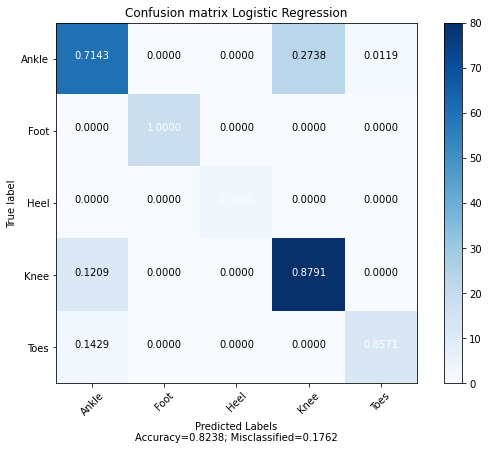

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


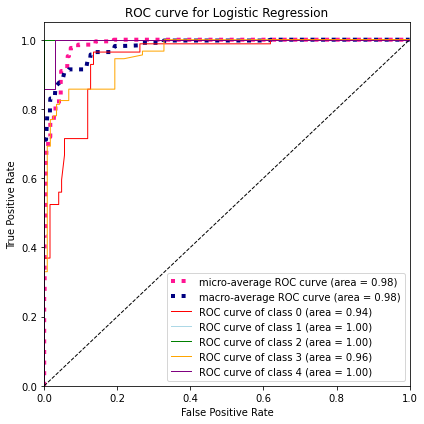

model has no attribute feature_importances_!


In [91]:
lr_model = LogisticRegression(max_iter=5000)
train_time = train(lr_model, X_train ,y_train)
y_pred, pred_time = test(lr_model, X_test)
plot_performance_results(lr_model, "Logistic Regression", y_pred, y_test, X_train, X_test, train_time, pred_time)

Decision Tree Classifier
Training time: 0.00497889518737793 secs
Prediction time: 0.001967906951904297 secs
Accuracy: 0.9619047619047619
Macro Precision: 0.9821717171717171
Macro Recall: 0.9554945054945054
Macro F Score: 0.9670361873405604
Micro Precision: 0.9619047619047619
Micro Recall: 0.9619047619047619
Micro F Score: 0.9619047619047619


Confusion Matrix Decision Tree Classifier:


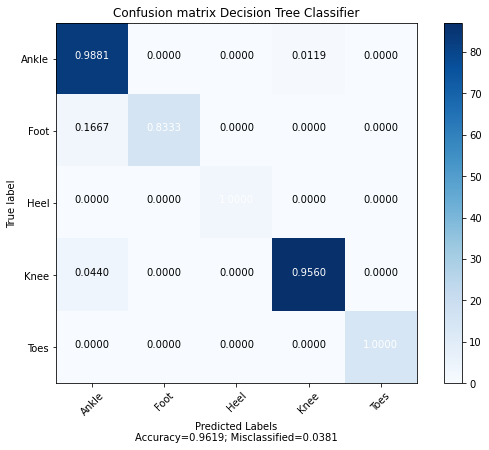

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


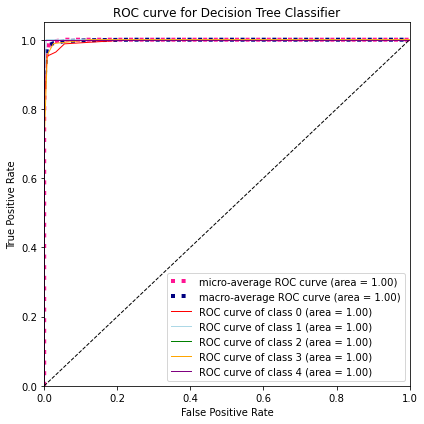

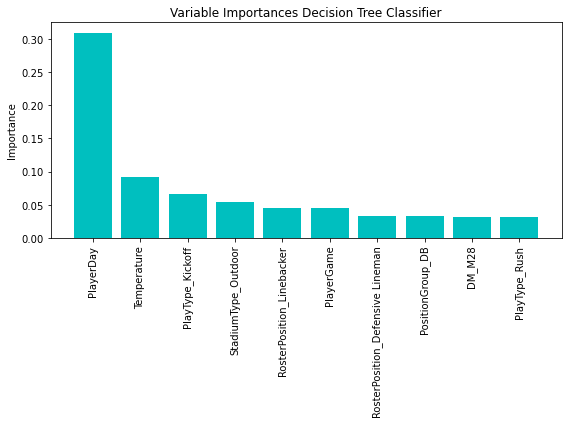

In [92]:
dtc_model = DecisionTreeClassifier(max_depth=8)
train_time = train(dtc_model, X_train ,y_train)
y_pred, pred_time = test(dtc_model, X_test)
plot_performance_results(dtc_model, "Decision Tree Classifier", y_pred, y_test, X_train, X_test, train_time, pred_time)

Random Forest
Training time: 0.1648578643798828 secs
Prediction time: 0.02530074119567871 secs
Accuracy: 0.9714285714285714
Macro Precision: 0.9876288659793815
Macro Recall: 0.9857142857142858
Macro F Score: 0.9862096138691883
Micro Precision: 0.9714285714285714
Micro Recall: 0.9714285714285714
Micro F Score: 0.9714285714285714


Confusion Matrix Random Forest:


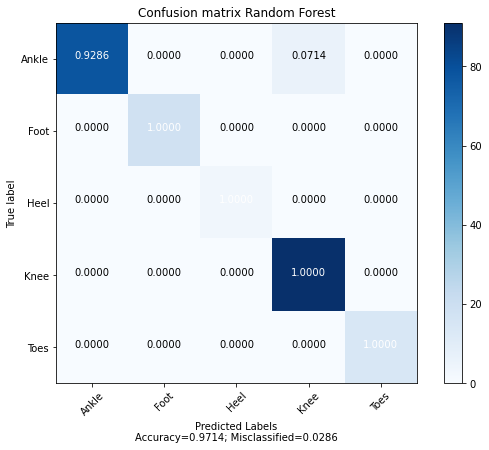

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


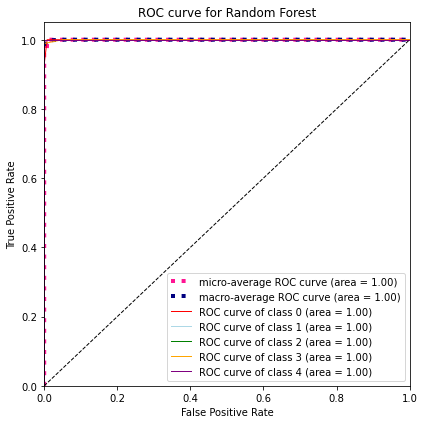

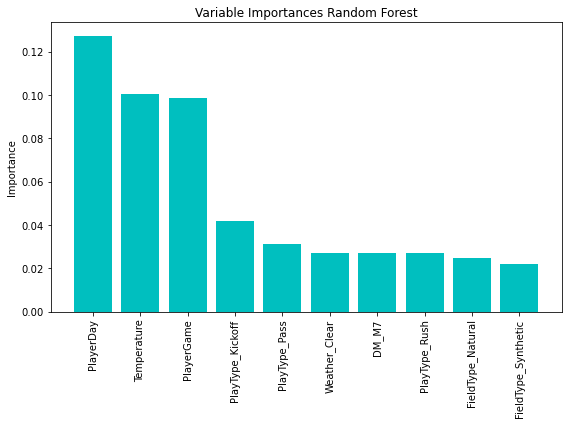

In [93]:
#Random Forest
rfc_model = RandomForestClassifier(n_estimators=128,
                                max_features='auto',
                                n_jobs = 8,
                                random_state = 42)
train_time = train(rfc_model, X_train ,y_train)
y_pred, pred_time = test(rfc_model, X_test)
plot_performance_results(rfc_model, "Random Forest", y_pred, y_test, X_train, X_test, train_time, pred_time)

C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:27:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:27:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier
Training time: 1.843038558959961 secs
Prediction time: 0.00498509407043457 secs
Accuracy: 0.9714285714285714
Macro Precision: 0.9876288659793815
Macro Recall: 0.9857142857142858
Macro F Score: 0.9862096138691883
Micro Precision: 0.9714285714285714
Micro Recall: 0.9714285714285714
Micro F Score: 0.9714285714285714


Confusion Matrix XGB Classifier:


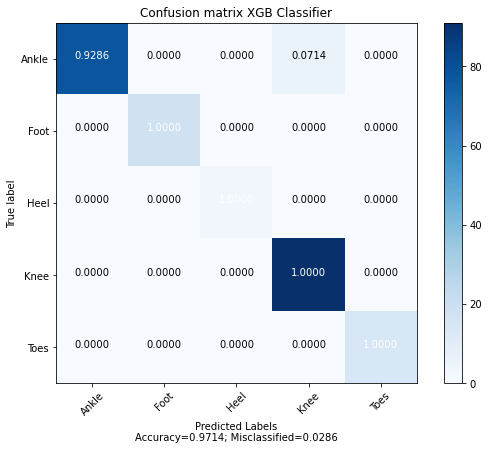

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


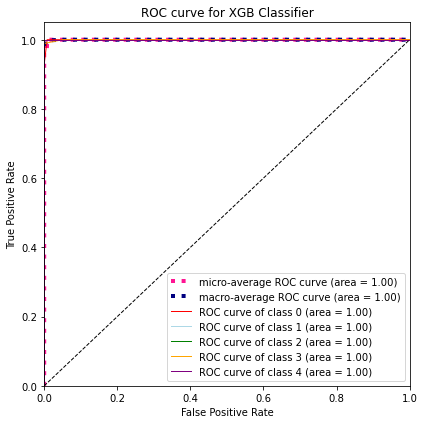

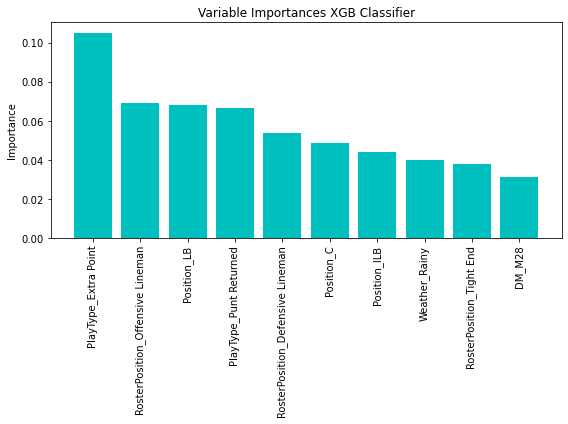

In [94]:
#XGBoost 
xgb_model = xgb.XGBClassifier(max_depth=4,
                      learning_rate=0.1,
                      n_estimators=450,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=0)

train_time = train(xgb_model, X_train ,y_train)
y_pred, pred_time = test(xgb_model, X_test)
plot_performance_results(xgb_model, "XGB Classifier", y_pred, y_test, X_train, X_test, train_time, pred_time)

C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi-Layer Perceptron
Training time: 0.9534509181976318 secs
Prediction time: 0.0019936561584472656 secs
Accuracy: 0.9714285714285714
Macro Precision: 0.9876288659793815
Macro Recall: 0.9857142857142858
Macro F Score: 0.9862096138691883
Micro Precision: 0.9714285714285714
Micro Recall: 0.9714285714285714
Micro F Score: 0.9714285714285714


Confusion Matrix Multi-Layer Perceptron:


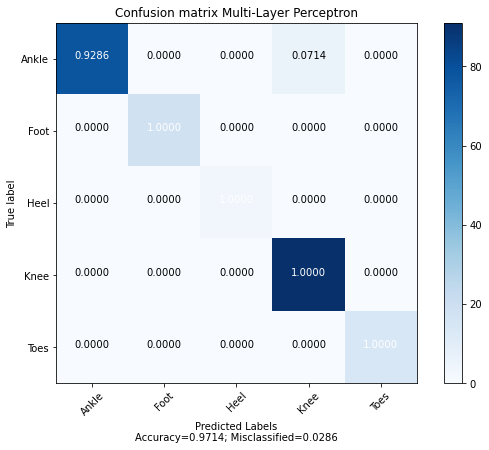

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


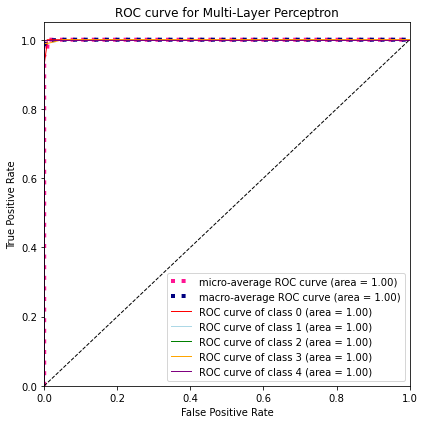

model has no attribute feature_importances_!


In [101]:
#Multi-Layer Perceptron
mlp_model =  MLPClassifier(random_state=5)
train_time = train(mlp_model, X_train ,y_train)
y_pred, pred_time = test(mlp_model, X_test)
plot_performance_results(mlp_model, "Multi-Layer Perceptron", y_pred, y_test, X_train, X_test, train_time, pred_time)

In [102]:
X_oversampled

,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
0,1,1,1,1,15,3,89,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,394,20,84,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1,1,1,1,8,2,83,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,1,1,0,365,8,81,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1,1,1,0,393,19,79,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1,0,0,0,84,12,69,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1046,1,1,0,0,36,6,85,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1047,1,0,0,0,71,10,68,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1048,1,1,0,0,50,7,61,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [103]:
Y_oversampled

0       Knee
1       Knee
2       Foot
3       Foot
4       Knee
        ... 
1045    Toes
1046    Toes
1047    Toes
1048    Toes
1049    Toes
Name: BodyPart, Length: 1050, dtype: object

In [104]:
#convert to numerical values for the NNs
y_cat_numerical = categorical_to_numerical(Y_oversampled, 'BodyPart')
y_cat_numerical

0       3
1       3
2       1
3       1
4       3
       ..
1045    4
1046    4
1047    4
1048    4
1049    4
Name: BodyPart, Length: 1050, dtype: object

In [105]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_oversampled, y_cat_numerical, test_size=0.3, random_state=21, shuffle=True)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [106]:
y_true_numeric = Y_test

In [107]:
#one hot-encode the numerical target labels 
tf.keras.utils.to_categorical
Y_train = tf.keras.utils.to_categorical(Y_train, 5)
Y_test = tf.keras.utils.to_categorical(Y_test, 5)
Y_val = tf.keras.utils.to_categorical(Y_val, 5)
print(Y_train)
print(Y_val)
print(Y_test)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0.

In [108]:
X_train.shape

(735, 55)

In [109]:
Y_test.shape[1]

5

In [112]:
checkpoint = callbacks.ModelCheckpoint('lstm_model_s2.h5', 
                                       save_best_only=True)

model_lstm = Sequential()
model_lstm.add(Embedding(X_train.shape[0] + 1, Y_test.shape[1] ,input_length=X_train.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(X_train.shape[1], dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(Y_test.shape[1], activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_lstm_train = time.time()

history = model_lstm.fit(X_train, Y_train, 
                    epochs=150, batch_size=8, 
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

end_lstm_train = time.time()
lstm_train_time = end_lstm_train - start_lstm_train

Epoch 1/150
92/92 [==============================] - 10s 68ms/step - loss: 1.2031 - accuracy: 0.4204 - val_loss: 1.0554 - val_accuracy: 0.5096
Epoch 2/150
92/92 [==============================] - 6s 66ms/step - loss: 1.1332 - accuracy: 0.4653 - val_loss: 1.0538 - val_accuracy: 0.5096
Epoch 3/150
92/92 [==============================] - 6s 65ms/step - loss: 1.1342 - accuracy: 0.4177 - val_loss: 1.0624 - val_accuracy: 0.3822
Epoch 4/150
92/92 [==============================] - 6s 67ms/step - loss: 1.1337 - accuracy: 0.4585 - val_loss: 1.0511 - val_accuracy: 0.5096
Epoch 5/150
92/92 [==============================] - 7s 75ms/step - loss: 1.1331 - accuracy: 0.4272 - val_loss: 1.0624 - val_accuracy: 0.5096
Epoch 6/150
92/92 [==============================] - 7s 74ms/step - loss: 1.1343 - accuracy: 0.4245 - val_loss: 1.0546 - val_accuracy: 0.5096
Epoch 7/150
92/92 [==============================] - 7s 76ms/step - loss: 1.1320 - accuracy: 0.4381 - val_loss: 1.0583 - val_accuracy: 0.5096
Epoch

92/92 [==============================] - 7s 79ms/step - loss: 0.6361 - accuracy: 0.7252 - val_loss: 0.6189 - val_accuracy: 0.7134
Epoch 105/150
92/92 [==============================] - 6s 71ms/step - loss: 0.6753 - accuracy: 0.6898 - val_loss: 0.5141 - val_accuracy: 0.7580
Epoch 106/150
92/92 [==============================] - 7s 72ms/step - loss: 0.6292 - accuracy: 0.7197 - val_loss: 0.5057 - val_accuracy: 0.7771
Epoch 107/150
92/92 [==============================] - 7s 74ms/step - loss: 0.6078 - accuracy: 0.7415 - val_loss: 0.5157 - val_accuracy: 0.7771
Epoch 108/150
92/92 [==============================] - 7s 72ms/step - loss: 0.5995 - accuracy: 0.7456 - val_loss: 0.4751 - val_accuracy: 0.8153
Epoch 109/150
92/92 [==============================] - 7s 72ms/step - loss: 0.5929 - accuracy: 0.7687 - val_loss: 0.5406 - val_accuracy: 0.7962
Epoch 110/150
92/92 [==============================] - 7s 71ms/step - loss: 0.5972 - accuracy: 0.7537 - val_loss: 0.4476 - val_accuracy: 0.8471
Epoch 

In [113]:
model_lstm = tf.keras.models.load_model('lstm_model_s2.h5')
start_lstm_pred = time.time()
y_pred = model_lstm.predict(X_test)
end_lstm_pred = time.time()
lstm_pred_time = end_lstm_pred - start_lstm_pred

In [114]:
model_lstm.evaluate(X_test, Y_test)[1]

5/5 [==============================] - 0s 12ms/step - loss: 0.2352 - accuracy: 0.9304


0.9303797483444214

In [115]:
y_pred

array([[5.22125105e-04, 4.16875118e-03, 1.56650458e-05, 9.93885219e-01,
        1.40830001e-03],
       [1.43246606e-01, 1.56286347e-03, 1.33245980e-04, 3.01839095e-02,
        8.24873328e-01],
       [6.09565992e-04, 6.34157332e-04, 4.17492316e-07, 9.97892201e-01,
        8.63649359e-04],
       [7.50645101e-02, 9.01348233e-01, 5.93458710e-04, 2.26759091e-02,
        3.17936385e-04],
       [1.54926917e-02, 9.54725623e-01, 1.44755075e-04, 2.88113188e-02,
        8.25588824e-04],
       [5.28118201e-02, 8.18474000e-05, 2.19523690e-06, 9.43003476e-01,
        4.10063658e-03],
       [6.36524335e-02, 9.22232032e-01, 1.03064871e-04, 1.29516032e-02,
        1.06079585e-03],
       [1.93024173e-01, 1.21563934e-02, 3.34356283e-03, 7.89813459e-01,
        1.66235538e-03],
       [3.48344038e-04, 1.24601088e-03, 1.34133406e-05, 9.89710152e-01,
        8.68205354e-03],
       [1.44836023e-01, 1.14390077e-02, 5.27521037e-03, 8.37559998e-01,
        8.89793679e-04],
       [6.09565992e-04, 6.3415

In [116]:
pred_classes = get_predicted_class(y_pred)
pred_classes 

[3,
 4,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 4,
 3,
 0,
 3,
 4,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 1,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 4,
 4,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 3,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 4,
 1,
 0,
 3,
 3,
 0,
 0,
 4,
 3,
 3,
 1,
 0,
 3,
 1,
 3,
 3,
 4,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 0,
 1,
 3,
 0,
 0,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 1,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 4,
 0,
 4,
 3,
 4,
 0,
 0,
 3,
 3,
 3,
 3,
 0,
 0,
 3,
 1,
 3,
 3,
 3,
 0,
 3]

In [117]:
#convert predictions to categorical
pred_categorical = convert_to_categorical_labels(pred_classes)
pred_categorical

['Knee',
 'Toes',
 'Knee',
 'Foot',
 'Foot',
 'Knee',
 'Foot',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Toes',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Toes',
 'Toes',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Toes',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Toes',
 'Knee',
 'Knee',
 'Foot',
 'Ankle',
 'Knee',
 'Foot',
 'Knee',
 'Knee',
 'Toes',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'F

In [118]:
y_true_categorical = convert_to_categorical_labels(y_true_numeric)
y_true_categorical

['Knee',
 'Toes',
 'Knee',
 'Foot',
 'Foot',
 'Knee',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Knee',
 'Toes',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Heel',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Toes',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Knee',
 'Foot',
 'Ankle',
 'Knee',
 'Foot',
 'Knee',
 'Knee',
 'Toes',
 'Heel',
 'Ankle',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'F

LSTM
Training time: 1019.9143295288086 secs
Prediction time: 0.3201324939727783 secs
Accuracy: 0.930379746835443
Macro Precision: 0.7418410633484164
Macro Recall: 0.7502886002886002
Macro F Score: 0.7454641403655389
Micro Precision: 0.930379746835443
Micro Recall: 0.930379746835443
Micro F Score: 0.930379746835443


Confusion Matrix LSTM:


C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


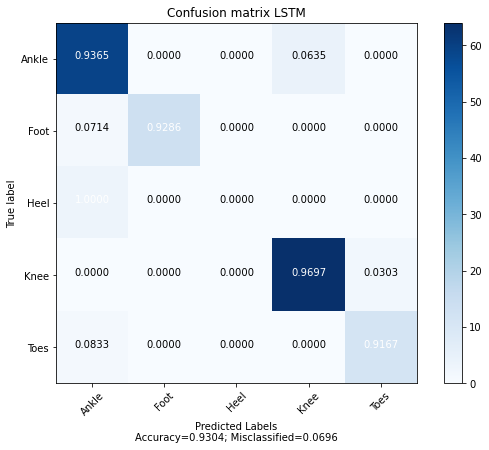

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


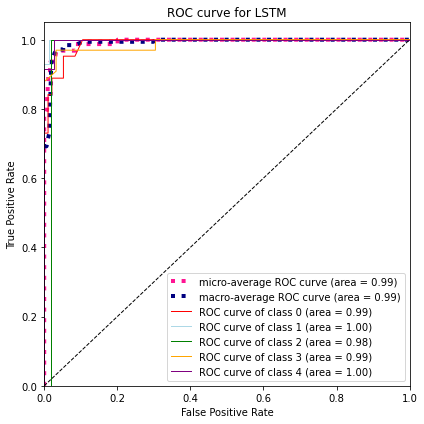

model has no attribute feature_importances_!


In [119]:
plot_performance_results(model_lstm, "LSTM", pred_categorical, y_true_categorical, X_train, X_test, lstm_train_time, lstm_pred_time, y_pred)

In [126]:
checkpoint = callbacks.ModelCheckpoint('gru_model_s2.h5', 
                                       save_best_only=True)

model_gru = Sequential()
model_gru.add(Embedding(X_train.shape[0] + 1, Y_test.shape[1] ,input_length=X_train.shape[1]))
model_gru.add(SpatialDropout1D(0.2))
model_gru.add(GRU(X_train.shape[1], dropout=0.2, recurrent_dropout=0.2))
model_gru.add(Dense(Y_test.shape[1], activation='softmax'))

model_gru.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['acc'])

start_gru_train = time.time()

history = model_gru.fit(X_train, Y_train, 
                    epochs=150, batch_size=8, 
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

end_gru_train = time.time()
gru_train_time = end_gru_train - start_gru_train

Epoch 1/150
92/92 [==============================] - 9s 62ms/step - loss: 1.2754 - acc: 0.4313 - val_loss: 1.0715 - val_acc: 0.5096
Epoch 2/150
92/92 [==============================] - 6s 60ms/step - loss: 1.1366 - acc: 0.4231 - val_loss: 1.0559 - val_acc: 0.5096
Epoch 3/150
92/92 [==============================] - 6s 61ms/step - loss: 1.1419 - acc: 0.4313 - val_loss: 1.0584 - val_acc: 0.5096
Epoch 4/150
92/92 [==============================] - 6s 61ms/step - loss: 1.1361 - acc: 0.4150 - val_loss: 1.0624 - val_acc: 0.5096
Epoch 5/150
92/92 [==============================] - 6s 69ms/step - loss: 1.1293 - acc: 0.4490 - val_loss: 1.0614 - val_acc: 0.3822
Epoch 6/150
92/92 [==============================] - 7s 72ms/step - loss: 1.1330 - acc: 0.4231 - val_loss: 1.0477 - val_acc: 0.5096
Epoch 7/150
92/92 [==============================] - 7s 71ms/step - loss: 1.1379 - acc: 0.4381 - val_loss: 1.0628 - val_acc: 0.3822
Epoch 8/150
92/92 [==============================] - 6s 67ms/step - loss: 1.

92/92 [==============================] - 7s 74ms/step - loss: 0.3653 - acc: 0.8680 - val_loss: 0.2280 - val_acc: 0.9045
Epoch 63/150
92/92 [==============================] - 6s 69ms/step - loss: 0.3970 - acc: 0.8599 - val_loss: 0.2473 - val_acc: 0.9172
Epoch 64/150
92/92 [==============================] - 7s 72ms/step - loss: 0.3855 - acc: 0.8503 - val_loss: 0.2632 - val_acc: 0.8981
Epoch 65/150
92/92 [==============================] - 6s 68ms/step - loss: 0.3556 - acc: 0.8735 - val_loss: 0.2509 - val_acc: 0.9045
Epoch 66/150
92/92 [==============================] - 6s 68ms/step - loss: 0.3540 - acc: 0.8612 - val_loss: 0.2347 - val_acc: 0.9108
Epoch 67/150
92/92 [==============================] - 7s 72ms/step - loss: 0.3764 - acc: 0.8612 - val_loss: 0.2188 - val_acc: 0.9236
Epoch 68/150
92/92 [==============================] - 7s 71ms/step - loss: 0.3293 - acc: 0.8789 - val_loss: 0.2721 - val_acc: 0.8790
Epoch 69/150
92/92 [==============================] - 6s 69ms/step - loss: 0.3458 

92/92 [==============================] - 7s 76ms/step - loss: 0.2016 - acc: 0.9333 - val_loss: 0.1045 - val_acc: 0.9682
Epoch 124/150
92/92 [==============================] - 7s 73ms/step - loss: 0.1768 - acc: 0.9361 - val_loss: 0.1015 - val_acc: 0.9490
Epoch 125/150
92/92 [==============================] - 6s 68ms/step - loss: 0.1740 - acc: 0.9347 - val_loss: 0.0887 - val_acc: 0.9618
Epoch 126/150
92/92 [==============================] - 7s 72ms/step - loss: 0.1750 - acc: 0.9333 - val_loss: 0.0974 - val_acc: 0.9490
Epoch 127/150
92/92 [==============================] - 7s 71ms/step - loss: 0.2375 - acc: 0.9075 - val_loss: 0.0885 - val_acc: 0.9745
Epoch 128/150
92/92 [==============================] - 6s 70ms/step - loss: 0.1920 - acc: 0.9347 - val_loss: 0.0863 - val_acc: 0.9745
Epoch 129/150
92/92 [==============================] - 7s 78ms/step - loss: 0.1891 - acc: 0.9333 - val_loss: 0.0800 - val_acc: 0.9682
Epoch 130/150
92/92 [==============================] - 7s 73ms/step - loss: 

In [127]:
model_gru = tf.keras.models.load_model('gru_model_s2.h5')
start_gru_pred = time.time()
y_pred = model_gru.predict(X_test)
end_gru_pred = time.time()
gru_pred_time = end_gru_pred - start_gru_pred

In [128]:
model_gru.evaluate(X_test, Y_test)[1]

5/5 [==============================] - 0s 15ms/step - loss: 0.0541 - acc: 0.9810


0.9810126423835754

In [129]:
y_pred

array([[2.71830242e-02, 2.20138973e-05, 8.69741939e-07, 9.72791314e-01,
        2.74573540e-06],
       [5.14415915e-05, 2.38110551e-05, 8.28270335e-03, 1.46469538e-04,
        9.91495609e-01],
       [1.38183136e-03, 1.98778298e-06, 2.26154260e-08, 9.98615980e-01,
        1.10881352e-07],
       [1.17605807e-04, 9.98674154e-01, 1.14564679e-03, 5.74027035e-05,
        5.19539890e-06],
       [5.67597686e-04, 9.97985601e-01, 5.55570179e-04, 8.49259377e-04,
        4.19619173e-05],
       [2.38709420e-01, 3.11653312e-05, 5.48028993e-07, 7.61257172e-01,
        1.65596680e-06],
       [1.50935623e-04, 9.98917460e-01, 7.95448781e-04, 9.94962247e-05,
        3.65728156e-05],
       [6.15320086e-01, 4.56098060e-05, 1.90880928e-06, 3.84609699e-01,
        2.26790980e-05],
       [1.09085022e-02, 5.97710914e-06, 3.35221330e-07, 9.89084184e-01,
        9.78141884e-07],
       [6.12636693e-02, 2.12863324e-05, 9.06809930e-07, 9.38708186e-01,
        5.90365471e-06],
       [1.38183136e-03, 1.9877

In [130]:
pred_classes = get_predicted_class(y_pred)
pred_classes 

[3,
 4,
 3,
 1,
 1,
 3,
 1,
 0,
 3,
 3,
 3,
 4,
 4,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 4,
 3,
 0,
 3,
 4,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 1,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 4,
 3,
 0,
 0,
 0,
 3,
 3,
 0,
 3,
 0,
 3,
 1,
 0,
 0,
 0,
 3,
 0,
 1,
 3,
 4,
 1,
 0,
 3,
 3,
 0,
 0,
 3,
 3,
 0,
 1,
 0,
 3,
 1,
 3,
 3,
 4,
 2,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 0,
 1,
 3,
 0,
 2,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 1,
 1,
 0,
 3,
 3,
 0,
 4,
 0,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 4,
 0,
 4,
 3,
 4,
 0,
 0,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 1,
 3,
 3,
 3,
 0,
 3]

In [131]:
#convert predictions to categorical
pred_categorical = convert_to_categorical_labels(pred_classes)
pred_categorical

['Knee',
 'Toes',
 'Knee',
 'Foot',
 'Foot',
 'Knee',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Knee',
 'Toes',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Heel',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Toes',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Foot',
 'Ankle',
 'Knee',
 'Foot',
 'Knee',
 'Knee',
 'Toes',
 'Heel',
 'Ankle',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'F

In [132]:
y_true_categorical = convert_to_categorical_labels(y_true_numeric)
y_true_categorical

['Knee',
 'Toes',
 'Knee',
 'Foot',
 'Foot',
 'Knee',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Knee',
 'Toes',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Heel',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Knee',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Toes',
 'Knee',
 'Ankle',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Foot',
 'Ankle',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Foot',
 'Knee',
 'Toes',
 'Foot',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Knee',
 'Knee',
 'Foot',
 'Ankle',
 'Knee',
 'Foot',
 'Knee',
 'Knee',
 'Toes',
 'Heel',
 'Ankle',
 'Knee',
 'Ankle',
 'Ankle',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Knee',
 'Knee',
 'Ankle',
 'Ankle',
 'F

GRU
Training time: 985.8332717418671 secs
Prediction time: 0.3690757751464844 secs
Accuracy: 0.9810126582278481
Macro Precision: 0.9906730769230769
Macro Recall: 0.9907647907647907
Macro F Score: 0.9906954378794254
Micro Precision: 0.9810126582278481
Micro Recall: 0.9810126582278481
Micro F Score: 0.9810126582278481


Confusion Matrix GRU:


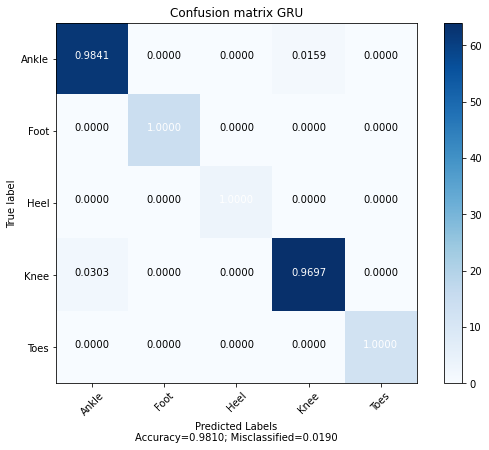

C:\Users\koutoua\AppData\Local\Temp\ipykernel_11664\3756429627.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


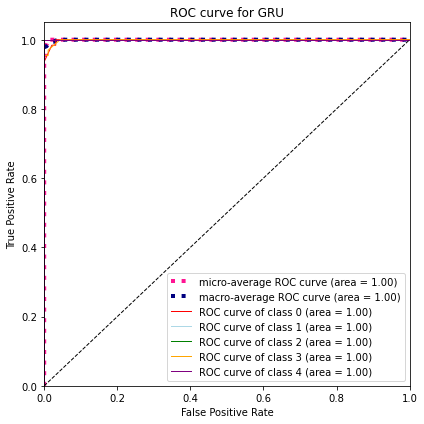

model has no attribute feature_importances_!


In [134]:
plot_performance_results(model_gru, "GRU", pred_categorical, y_true_categorical, X_train, X_test, gru_train_time, gru_pred_time, y_pred)

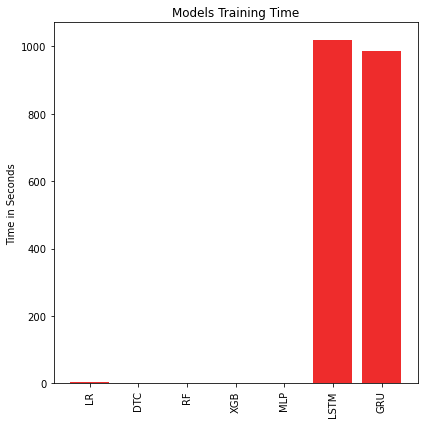

In [135]:
plot_bar_graph(training_times, "Models Training Time" , "Time in Seconds")

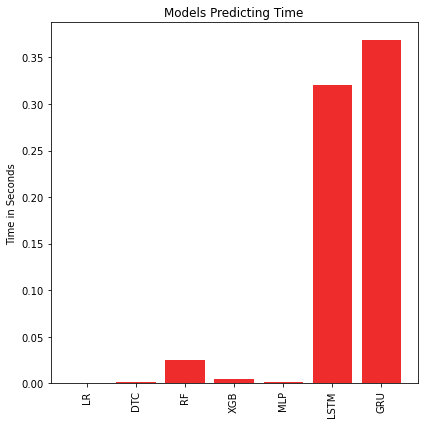

In [136]:
plot_bar_graph(predicting_times, "Models Predicting Time", "Time in Seconds")

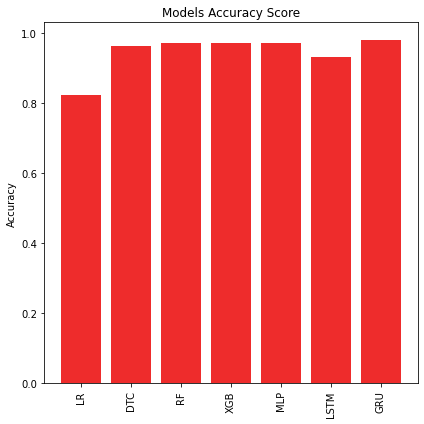

In [137]:
plot_bar_graph(accuracy_scores, "Models Accuracy Score", "Accuracy")

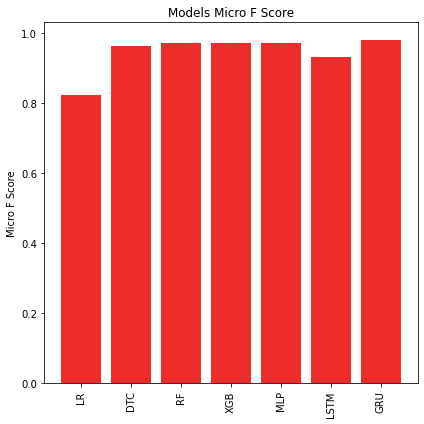

In [138]:
plot_bar_graph(micro_f_scores, "Models Micro F Score", "Micro F Score")